
<a id='multiplicative-functionals'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Multiplicative Functionals


<a id='index-0'></a>

## Contents

- [Multiplicative Functionals](#Multiplicative-Functionals)  
  - [Overview](#Overview)  
  - [A Log-Likelihood Process](#A-Log-Likelihood-Process)  
  - [Benefits from Reduced Aggregate Fluctuations](#Benefits-from-Reduced-Aggregate-Fluctuations)  

Co-authored with Chase Coleman and Balint Szoke

## Overview

This lecture is a sequel to the [lecture on additive functionals](additive_functionals.html).

That lecture

1. defined a special class of **additive functionals** driven by a first-order vector VAR  
1. by taking the exponential of that additive functional, created an associated **multiplicative functional**  


This lecture uses this special class to create and analyze two examples

- A  **log likelihood process**, an object at the foundation of both frequentist and Bayesian approaches to statistical inference.  
- A version of Robert E. Lucas’s [[Luc03]](../zreferences.html#lucas2003) and Thomas Tallarini’s [[Tal00]](../zreferences.html#tall2000) approaches to measuring the benefits of moderating aggregate fluctuations.  

## A Log-Likelihood Process

Consider a vector of additive functionals $ \{y_t\}_{t=0}^\infty $ described by

$$
\begin{aligned}
    x_{t+1} & = A x_t + B z_{t+1}
    \\
    y_{t+1} - y_t & = D x_{t} + F z_{t+1},
\end{aligned}
$$

where $ A $ is a stable matrix, $ \{z_{t+1}\}_{t=0}^\infty $ is
an i.i.d. sequence of $ {\cal N}(0,I) $ random vectors, $ F $ is
nonsingular, and $ x_0 $ and $ y_0 $ are vectors of known
numbers.

Evidently,

$$
x_{t+1} = \left(A - B F^{-1}D \right)x_t
    + B F^{-1} \left(y_{t+1} - y_t \right),
$$

so that $ x_{t+1} $ can be constructed from observations on
$ \{y_{s}\}_{s=0}^{t+1} $ and $ x_0 $.

The distribution of $ y_{t+1} - y_t $ conditional on $ x_t $ is normal with mean $ Dx_t $ and nonsingular covariance matrix $ FF' $.

Let $ \theta $ denote the vector of free parameters of the model.

These parameters pin down the elements of $ A, B, D, F $.

The **log likelihood function** of $ \{y_s\}_{s=1}^t $ is

$$
\begin{aligned}
    \log L_{t}(\theta)  =
    & - {\frac 1 2} \sum_{j=1}^{t} (y_{j} - y_{j-1} -
         D x_{j-1})'(FF')^{-1}(y_{j} - y_{j-1} - D x_{j-1})
    \\
    & - {\frac t 2} \log \det (FF') - {\frac {k t} 2} \log( 2 \pi)
\end{aligned}
$$

Let’s consider the case of a scalar process in which $ A, B, D, F $ are scalars and $ z_{t+1} $ is a scalar stochastic process.

We let $ \theta_o $ denote the “true” values of $ \theta $, meaning the values that generate the data.

For the purposes of this exercise,  set $ \theta_o = (A, B, D, F) = (0.8, 1, 0.5, 0.2) $.

Set $ x_0 = y_0 = 0 $.

### Simulating sample paths

Let’s write a program to simulate sample paths of $ \{ x_t, y_{t} \}_{t=0}^{\infty} $.

We’ll do this by formulating the additive functional as a linear state space model and putting the [LSS](https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/lss.jl) struct to work.

### Setup

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true) # uncomment to force package installation

In [2]:
using LinearAlgebra, Statistics
using Distributions, Parameters, Plots, QuantEcon
import Distributions: loglikelihood
gr(fmt = :png);

In [3]:
AMF_LSS_VAR = @with_kw (A, B, D, F = 0.0, ν = 0.0, lss = construct_ss(A, B, D, F, ν))

function construct_ss(A, B, D, F, ν)
    H, g = additive_decomp(A, B, D, F)

    # Build A matrix for LSS
    # Order of states is: [1, t, xt, yt, mt]
    A1 = [1 0 0 0 0]       # Transition for 1
    A2 = [1 1 0 0 0]       # Transition for t
    A3 = [0 0 A 0 0]       # Transition for x_{t+1}
    A4 = [ν 0 D 1 0]       # Transition for y_{t+1}
    A5 = [0 0 0 0 1]       # Transition for m_{t+1}
    Abar = vcat(A1, A2, A3, A4, A5)

    # Build B matrix for LSS
    Bbar = [0, 0, B, F, H]

    # Build G matrix for LSS
    # Order of observation is: [xt, yt, mt, st, tt]
    G1 = [0 0 1 0 0]               # Selector for x_{t}
    G2 = [0 0 0 1 0]               # Selector for y_{t}
    G3 = [0 0 0 0 1]               # Selector for martingale
    G4 = [0 0 -g 0 0]              # Selector for stationary
    G5 = [0 ν 0 0 0]               # Selector for trend
    Gbar = vcat(G1, G2, G3, G4, G5)

    # Build LSS struct
    x0 = [0, 0, 0, 0, 0]
    S0 = zeros(5, 5)
    return LSS(Abar, Bbar, Gbar, mu_0 = x0, Sigma_0 = S0)
end

function additive_decomp(A, B, D, F)
    A_res = 1 / (1 - A)
    g = D * A_res
    H = F + D * A_res * B

    return H, g
end

function multiplicative_decomp(A, B, D, F, ν)
    H, g = additive_decomp(A, B, D, F)
    ν_tilde = ν + 0.5 * H^2

    return ν_tilde, H, g
end

function loglikelihood_path(amf, x, y)
    @unpack A, B, D, F = amf
    T = length(y)
    FF = F^2
    FFinv = inv(FF)
    temp = y[2:end] - y[1:end-1] - D*x[1:end-1]
    obs =  temp .* FFinv .* temp
    obssum = cumsum(obs)
    scalar = (log(FF) + log(2pi)) * (1:T-1)
    return -0.5 * (obssum + scalar)
end

function loglikelihood(amf, x, y)
    llh = loglikelihood_path(amf, x, y)
    return llh[end]
end

loglikelihood (generic function with 4 methods)

The heavy lifting is done inside the AMF_LSS_VAR struct.

The following code adds some simple functions that make it straightforward to generate sample paths from an instance of AMF_LSS_VAR

In [4]:
function simulate_xy(amf, T)
    foo, bar = simulate(amf.lss, T)
    x = bar[1, :]
    y = bar[2, :]
    return x, y
end

function simulate_paths(amf, T = 150, I = 5000)
    # Allocate space
    storeX = zeros(I, T)
    storeY = zeros(I, T)

    for i in 1:I
        # Do specific simulation
        x, y = simulate_xy(amf, T)

        # Fill in our storage matrices
        storeX[i, :] = x
        storeY[i, :] = y
    end

    return storeX, storeY
end

function population_means(amf, T = 150)
    # Allocate Space
    xmean = zeros(T)
    ymean = zeros(T)

    # Pull out moment generator
    moment_generator = moment_sequence(amf.lss)
    for (tt, x) = enumerate(moment_generator)
        ymeans = x[2]
        xmean[tt] = ymeans[1]
        ymean[tt] = ymeans[2]
        if tt == T
            break
        end
    end
    return xmean, ymean
end

population_means (generic function with 2 methods)

Now that we have these functions in our took kit, let’s apply them to run some
simulations.

In particular, let’s use our program to generate $ I = 5000 $ sample paths of length $ T = 150 $, labeled $ \{ x_{t}^i, y_{t}^i \}_{t=0}^\infty $ for $ i = 1, ..., I $.

Then we compute averages of $ \frac{1}{I} \sum_i x_t^i $ and $ \frac{1}{I} \sum_i y_t^i $ across the sample paths and compare them with the population means of $ x_t $ and $ y_t $.

Here goes

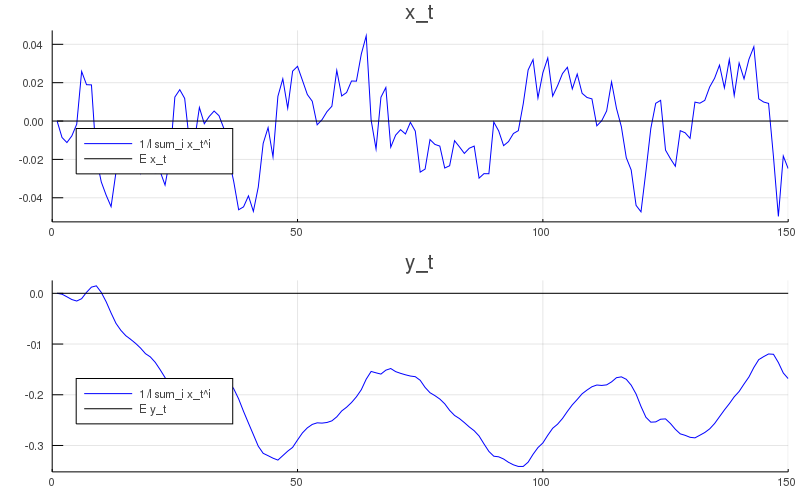

In [5]:
F = 0.2
amf = AMF_LSS_VAR(A = 0.8, B = 1.0, D = 0.5, F = F)

T = 150
I = 5000

# Simulate and compute sample means
Xit, Yit = simulate_paths(amf, T, I)
Xmean_t = mean(Xit, dims = 1)
Ymean_t = mean(Yit, dims = 1)

# Compute population means
Xmean_pop, Ymean_pop = population_means(amf, T)

# Plot sample means vs population means
plt_1 = plot(Xmean_t', color = :blue, label = "1/I sum_i x_t^i")
plot!(plt_1, Xmean_pop, color = :black, label = "E x_t")
plot!(plt_1, title = "x_t", xlim = (0, T), legend = :bottomleft)

plt_2 = plot(Ymean_t', color = :blue, label = "1/I sum_i x_t^i")
plot!(plt_2, Ymean_pop, color = :black, label = "E y_t")
plot!(plt_2, title = "y_t", xlim = (0, T), legend = :bottomleft)

plot(plt_1, plt_2, layout = (2, 1), size = (800,500))

### Simulating log-likelihoods

Our next aim is to write a program to simulate $ \{\log L_t \mid \theta_o\}_{t=1}^T $.

We want as inputs to this program the *same* sample paths $ \{x_t^i, y_t^i\}_{t=0}^T $ that we  have already computed.

We now want to simulate $ I = 5000 $ paths of $ \{\log L_t^i  \mid \theta_o\}_{t=1}^T $.

- For each path, we compute $ \log L_T^i / T $.  
- We also compute $ \frac{1}{I} \sum_{i=1}^I \log L_T^i / T $.  


Then we to compare these objects.

Below we plot the histogram of $ \log L_T^i / T $ for realizations $ i = 1, \ldots, 5000 $

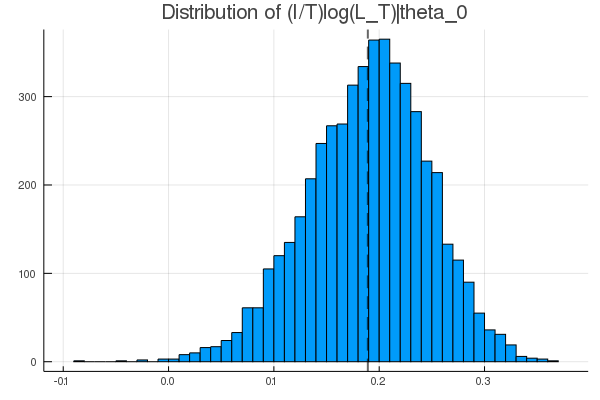

In [6]:
function simulate_likelihood(amf, Xit, Yit)
    # Get size
    I, T = size(Xit)

    # Allocate space
    LLit = zeros(I, T-1)

    for i in 1:I
        LLit[i, :] = loglikelihood_path(amf, Xit[i, :], Yit[i, :])
    end

    return LLit
end

# Get likelihood from each path x^{i}, Y^{i}
LLit = simulate_likelihood(amf, Xit, Yit)

LLT = 1 / T * LLit[:, end]
LLmean_t = mean(LLT)

plot(seriestype = :histogram, LLT, label = "")
plot!(title = "Distribution of (I/T)log(L_T)|theta_0")
vline!([LLmean_t], linestyle = :dash, color = :black, lw = 2, alpha = 0.6, label = "")

Notice that the log likelihood is almost always nonnegative, implying that $ L_t $ is typically bigger than 1.

Recall that the likelihood function is a pdf (probability density function) and **not** a probability measure, so it can take values larger than 1.

In the current case, the conditional variance of $ \Delta y_{t+1} $, which equals  $ FF^T=0.04 $, is so small that the maximum value of the pdf is 2 (see the figure below).

This implies that approximately $ 75\% $ of the time (a bit more than one sigma deviation),  we should expect the **increment** of the log likelihood to be nonnegative.

Let’s see this in a simulation

In [7]:
normdist = Normal(0, F)
mult = 1.175
println("The pdf at +/- $mult sigma takes the value: $(pdf(normdist,mult*F))")
println("Probability of dL being larger than 1 is approx: "*
        "$(cdf(normdist,mult*F)-cdf(normdist,-mult*F))")

# Compare this to the sample analogue:
L_increment = LLit[:,2:end] - LLit[:,1:end-1]
r,c = size(L_increment)
frac_nonegative = sum(L_increment.>=0)/(c*r)
print("Fraction of dlogL being nonnegative in the sample is: $(frac_nonegative)")

The pdf at +/- 1.175 sigma takes the value: 1.0001868966924388
Probability of dL being larger than 1 is approx: 0.7600052842019751


Fraction of dlogL being nonnegative in the sample is: 0.7604337837837838

Let’s also plot the conditional pdf of $ \Delta y_{t+1} $

The pdf at +/- one sigma takes the value: 1.2098536225957168 


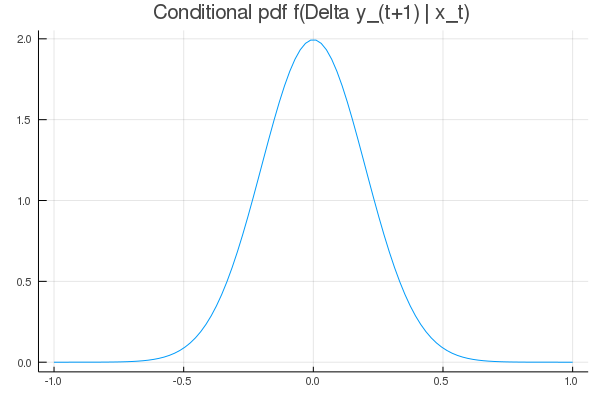

In [8]:
xgrid = range(-1,  1, length = 100)
println("The pdf at +/- one sigma takes the value: $(pdf(normdist, F)) ")
plot(xgrid, pdf.(normdist, xgrid), label = "")
plot!(title = "Conditional pdf f(Delta y_(t+1) | x_t)")

### An alternative parameter vector

Now consider alternative parameter vector $ \theta_1 = [A, B, D, F] = [0.9, 1.0, 0.55, 0.25] $.

We want to compute $ \{\log L_t \mid \theta_1\}_{t=1}^T $.

The $ x_t, y_t $ inputs to this program should be exactly the **same** sample paths $ \{x_t^i, y_t^i\}_{t=0}^T $ that we we computed above.

This is because we want to generate data under the $ \theta_o $ probability model but evaluate the likelihood under the $ \theta_1 $ model.

So our task is to use our program to simulate $ I = 5000 $ paths of $ \{\log L_t^i  \mid \theta_1\}_{t=1}^T $.

- For each path, compute $ \frac{1}{T} \log L_T^i $.  
- Then compute $ \frac{1}{I}\sum_{i=1}^I \frac{1}{T} \log L_T^i $.  


We want to compare these objects with each other and with the analogous objects that we computed above.

Then we want to interpret outcomes.

A function that we constructed can  handle these tasks.

The only innovation is that we must create an alternative model to feed in.

We will creatively call the new model `amf2`.

We make three graphs

- the first sets the stage by repeating an earlier graph  
- the second contains two histograms of values of  log likelihoods of the two models  over the period $ T $  
- the third compares likelihoods under the true and alternative models  


Here’s the code

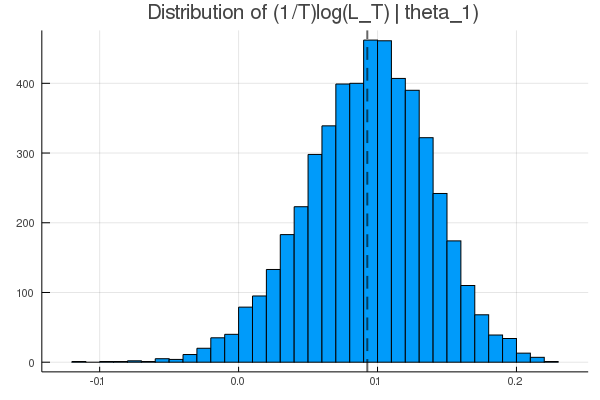

In [9]:
# Create the second (wrong) alternative model
amf2 = AMF_LSS_VAR(A = 0.9, B = 1.0, D = 0.55, F = 0.25) # parameters for θ_1 closer to θ_0

# Get likelihood from each path x^{i}, y^{i}
LLit2 = simulate_likelihood(amf2, Xit, Yit)

LLT2 = 1/(T-1) * LLit2[:, end]
LLmean_t2 = mean(LLT2)

plot(seriestype = :histogram, LLT2, label = "")
vline!([LLmean_t2], color = :black, lw = 2, linestyle = :dash, alpha = 0.6, label = "")
plot!(title = "Distribution of (1/T)log(L_T) | theta_1)")

Let’s see a histogram of the log-likelihoods under the true and the alternative model (same sample paths)

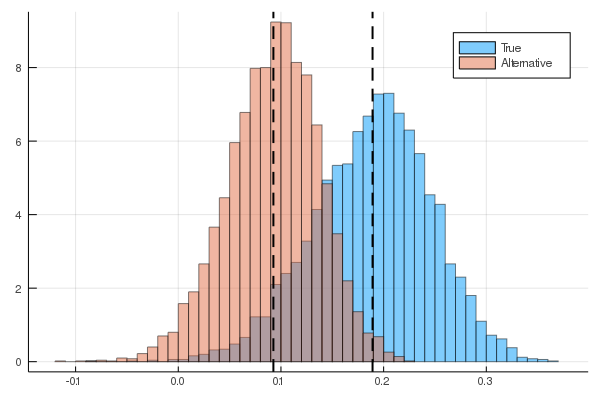

In [10]:
plot(seriestype = :histogram, LLT, bin = 50, alpha = 0.5, label = "True", normed = true)
plot!(seriestype = :histogram, LLT2, bin = 50, alpha = 0.5, label = "Alternative",
      normed = true)
vline!([mean(LLT)], color = :black, lw = 2, linestyle = :dash, label = "")
vline!([mean(LLT2)], color = :black, lw = 2, linestyle = :dash, label = "")

Now we’ll plot the histogram of the difference in log likelihood ratio

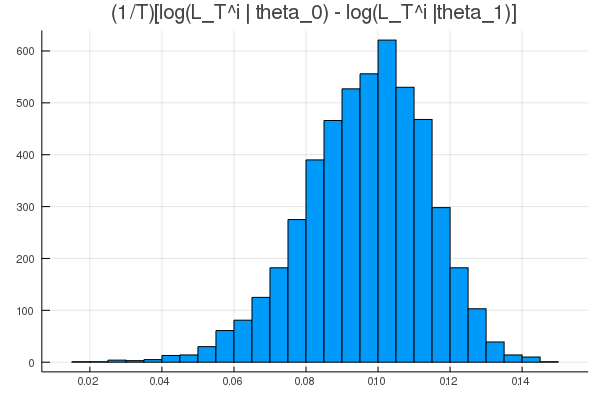

In [11]:
LLT_diff = LLT - LLT2

plot(seriestype = :histogram, LLT_diff, bin = 50, label = "")
plot!(title = "(1/T)[log(L_T^i | theta_0) - log(L_T^i |theta_1)]")

### Interpretation

These histograms of  log likelihood ratios illustrate  important features of **likelihood ratio tests** as tools for discriminating between statistical models.

- The loglikeklihood is higher on average under the true model – obviously a very useful property.  
- Nevertheless, for a positive fraction of realizations, the log likelihood is higher for the incorrect than for the true model  


> - in these instances, a likelihood ratio test mistakenly selects the wrong model  



- These mechanics underlie the statistical theory of **mistake probabilities** associated with model selection tests based on  likelihood ratio.  


(In a subsequent lecture, we’ll use some of the code prepared in this lecture to illustrate mistake probabilities)

## Benefits from Reduced Aggregate Fluctuations

Now let’s turn to a new example of multiplicative functionals.

This example illustrates  ideas in the literatures on

- **long-run risk** in the consumption based asset pricing literature (e.g., [[BY04]](../zreferences.html#bansalyaron2004), [[HHL08]](../zreferences.html#hhl2008), [[Han07]](../zreferences.html#hansen2007))  
- **benefits of eliminating aggregate fluctuations** in representative agent macro models (e.g., [[Tal00]](../zreferences.html#tall2000), [[Luc03]](../zreferences.html#lucas2003))  


Let $ c_t $ be consumption at date $ t \geq 0 $.

Suppose that $ \{\log c_t \}_{t=0}^\infty $ is an additive functional described by

$$
\log c_{t+1} - \log c_t = \nu + D \cdot x_t + F \cdot z_{t+1}
$$

where

$$
x_{t+1} = A x_t + B z_{t+1}
$$

Here $ \{z_{t+1}\}_{t=0}^\infty $ is an i.i.d. sequence of $ {\cal N}(0,I) $ random vectors.

A representative household ranks consumption processes $ \{c_t\}_{t=0}^\infty $ with a utility functional $ \{V_t\}_{t=0}^\infty $ that satisfies


<a id='equation-old1mf'></a>
$$
\log V_t - \log c_t = U \cdot x_t + {\sf u} \tag{1}
$$

where

$$
U = \exp(-\delta) \left[ I - \exp(-\delta) A' \right]^{-1} D
$$

and

$$
{\sf u}
  = {\frac {\exp( -\delta)}{ 1 - \exp(-\delta)}} {\nu} + \frac{(1 - \gamma)}{2} {\frac {\exp(-\delta)}{1 - \exp(-\delta)}}
\biggl| D' \left[ I - \exp(-\delta) A \right]^{-1}B + F \biggl|^2,
$$

Here $ \gamma \geq 1 $ is a risk-aversion coefficient and $ \delta > 0 $ is a rate of time preference.

### Consumption as a multiplicative process

We begin by showing that consumption is a **multiplicative functional** with representation


<a id='equation-old2mf'></a>
$$
\frac{c_t}{c_0}
= \exp(\tilde{\nu}t )
\left( \frac{\tilde{M}_t}{\tilde{M}_0} \right)
\left( \frac{\tilde{e}(x_0)}{\tilde{e}(x_t)} \right) \tag{2}
$$

where $ \left( \frac{\tilde{M}_t}{\tilde{M}_0} \right) $ is a likelihood ratio process and $ \tilde M_0 = 1 $.

At this point, as an exercise, we ask the reader please to verify the follow formulas for $ \tilde{\nu} $ and $ \tilde{e}(x_t) $ as functions of $ A, B, D, F $:

$$
\tilde \nu =  \nu + \frac{H \cdot H}{2}
$$

and

$$
\tilde e(x) = \exp[g(x)] = \exp \bigl[ D' (I - A)^{-1} x \bigr]
$$

### Simulating a likelihood ratio process again

Next, we want a program to simulate the likelihood ratio process $ \{ \tilde{M}_t \}_{t=0}^\infty $.

In particular, we want to simulate 5000 sample paths of length $ T=1000 $ for the case in which $ x $ is a scalar and $ [A, B, D, F] = [0.8, 0.001, 1.0, 0.01] $ and $ \nu = 0.005 $.

After accomplishing this, we want to display a histogram of $ \tilde{M}_T^i $ for
$ T=1000 $.

Here is code that accomplishes these tasks

In [12]:
function simulate_martingale_components(amf, T = 1_000, I = 5_000)
    # Get the multiplicative decomposition
    @unpack A, B, D, F, ν, lss = amf
    ν, H, g = multiplicative_decomp(A, B, D, F, ν)

    # Allocate space
    add_mart_comp = zeros(I, T)

    # Simulate and pull out additive martingale component
    for i in 1:I
        foo, bar = simulate(lss, T)
        # Martingale component is third component
        add_mart_comp[i, :] = bar[3, :]
    end

    mul_mart_comp = exp.(add_mart_comp' .- (0:T-1) * H^2 / 2)'

    return add_mart_comp, mul_mart_comp
end

# Build model
amf_2 = AMF_LSS_VAR(A = 0.8, B = 0.001, D = 1.0, F = 0.01, ν = 0.005)

amc, mmc = simulate_martingale_components(amf_2, 1_000, 5_000)

amcT = amc[:, end]
mmcT = mmc[:, end]

println("The (min, mean, max) of additive Martingale component in period T is")
println("\t ($(minimum(amcT)), $(mean(amcT)), $(maximum(amcT)))")

println("The (min, mean, max) of multiplicative Martingale component in period T is")
println("\t ($(minimum(mmcT)), $(mean(mmcT)), $(maximum(mmcT)))")

The (min, mean, max) of additive Martingale component in period T is
	 (-1.6221174825693974, -0.0013398294283933367, 1.8793802311502166)
The (min, mean, max) of multiplicative Martingale component in period T is
	 (0.17648754307656175, 1.0010245491442704, 5.8532246473742)


#### Comments

- The preceding min, mean, and max of the cross-section of the date
  $ T $ realizations of the multiplicative martingale component of
  $ c_t $ indicate that the sample mean is close to its population
  mean of 1.  
  
  - This outcome prevails for all values of the horizon $ T $.  
  
- The cross-section distribution of the multiplicative martingale
  component of $ c $ at date $ T $ approximates a log normal
  distribution well.  
- The histogram of the additive martingale component of
  $ \log c_t $ at date $ T $ approximates a normal distribution
  well.  


Here’s a histogram of the additive martingale component

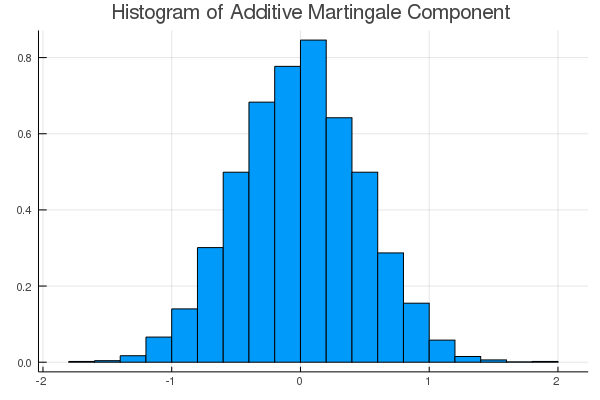

In [13]:
plot(seriestype = :histogram, amcT, bin = 25, normed = true, label = "")
plot!(title = "Histogram of Additive Martingale Component")

Here’s a histogram of the multiplicative martingale component

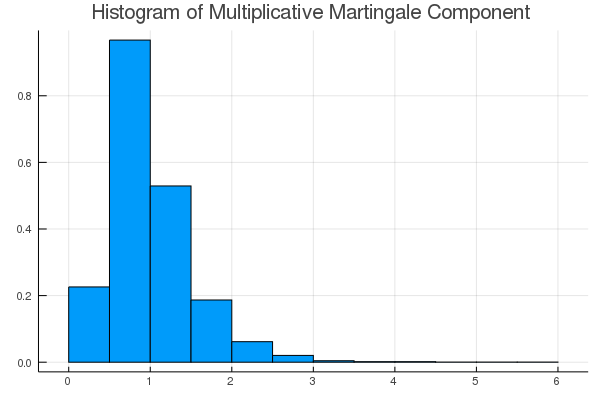

In [14]:
plot(seriestype = :histogram, mmcT, bin = 25, normed = true, label = "")
plot!(title = "Histogram of Multiplicative Martingale Component")

### Representing the likelihood ratio process

The likelihood ratio process $ \{\widetilde M_t\}_{t=0}^\infty $ can be represented as

$$
\widetilde M_t = \exp \biggl( \sum_{j=1}^t \biggl(H \cdot z_j -\frac{ H \cdot H }{2} \biggr) \biggr),  \quad \widetilde M_0 =1 ,
$$

where $ H =  [F + B'(I-A')^{-1} D] $.

It follows that $ \log {\widetilde M}_t \sim {\mathcal N} ( -\frac{t H \cdot H}{2}, t H \cdot H ) $ and that consequently $ {\widetilde M}_t $ is log normal.

Let’s plot the probability density functions for $ \log {\widetilde M}_t $ for
$ t=100, 500, 1000, 10000, 100000 $.

Then let’s use the plots to  investigate how these densities evolve through time.

We will plot the densities of $ \log {\widetilde M}_t $ for different values of $ t $.

Here is some code that tackles these tasks

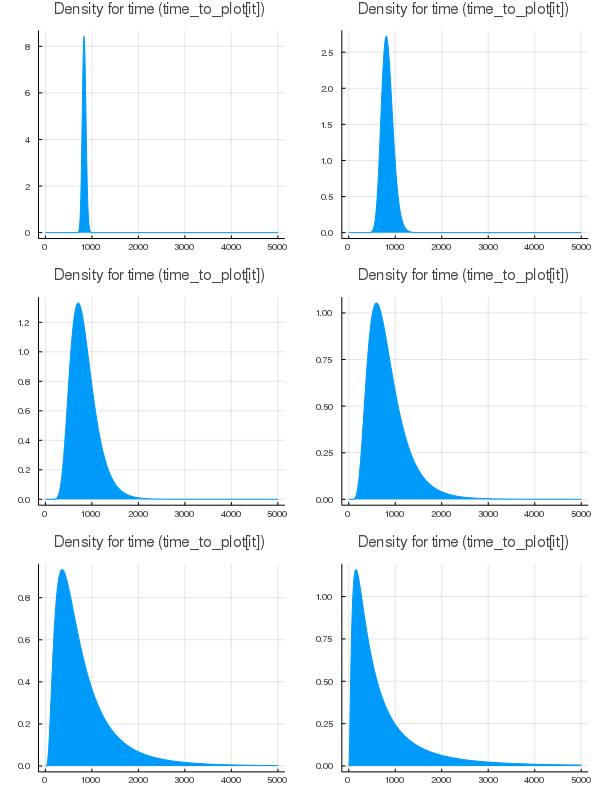

In [15]:
function Mtilde_t_density(amf, t; xmin = 1e-8, xmax = 5.0, npts = 5000)

    # Pull out the multiplicative decomposition
    νtilde, H, g =
        multiplicative_decomp(amf.A, amf.B, amf.D, amf.F, amf.ν)
    H2 = H*H

    # The distribution
    mdist = LogNormal(-t * H2 / 2, sqrt(t * H2))
    x = range(xmin,  xmax, length = npts)
    p = pdf.(mdist, x)

    return x, p
end

function logMtilde_t_density(amf, t; xmin = -15.0, xmax = 15.0, npts = 5000)

    # Pull out the multiplicative decomposition
    @unpack A, B, D, F, ν = amf
    νtilde, H, g = multiplicative_decomp(A, B, D, F, ν)
    H2 = H * H

    # The distribution
    lmdist = Normal(-t * H2 / 2, sqrt(t * H2))
    x = range(xmin,  xmax, length = npts)
    p = pdf.(lmdist, x)

    return x, p
end

times_to_plot = [10, 100, 500, 1000, 2500, 5000]
dens_to_plot = [Mtilde_t_density(amf_2, t, xmin=1e-8, xmax=6.0) for t in times_to_plot]
ldens_to_plot = [logMtilde_t_density(amf_2, t, xmin=-10.0, xmax=10.0) for t in times_to_plot]

# plot_title = "Densities of M_t^tilda" is required, however, plot_title is not yet
# supported in Plots
plots = plot(layout = (3,2), size = (600,800))

for (it, dens_t) in enumerate(dens_to_plot)
    x, pdf = dens_t
    plot!(plots[it], title = "Density for time (time_to_plot[it])")
    plot!(plots[it], pdf, fillrange = [[0], pdf], label = "")
end
plot(plots)

These probability density functions illustrate a **peculiar property** of log likelihood ratio processes:

- With respect to the true model probabilities, they have mathematical expectations equal to $ 1 $ for all $ t \geq 0 $.  
- They almost surely converge to zero.  

### Welfare benefits of reduced random aggregate fluctuations

Suppose in the tradition of a strand of macroeconomics (for example Tallarini [[Tal00]](../zreferences.html#tall2000), [[Luc03]](../zreferences.html#lucas2003)) we want to estimate the welfare benefits from removing random fluctuations around trend growth.

We shall  compute how much initial consumption $ c_0 $ a representative consumer who ranks consumption streams according to [(1)](#equation-old1mf) would be willing to sacrifice to enjoy the consumption stream

$$
\frac{c_t}{c_0} = \exp (\tilde{\nu} t)
$$

rather than the stream described by equation [(2)](#equation-old2mf).

We want to compute the implied percentage reduction in $ c_0 $ that the representative consumer would accept.

To accomplish this, we write a function that computes the coefficients $ U $
and $ u $ for the original values of $ A, B, D, F, \nu $, but
also for the case that  $ A, B, D, F = [0, 0, 0, 0] $ and
$ \nu = \tilde{\nu} $.

Here’s our code

In [16]:
function Uu(amf, δ, γ)
    @unpack A, B, D, F, ν = amf
    ν_tilde, H, g = multiplicative_decomp(A, B, D, F, ν)

    resolv = 1 / (1 - exp(-δ) * A)
    vect = F + D * resolv * B

    U_risky = exp(-δ) * resolv * D
    u_risky = exp(-δ) / (1 - exp(-δ)) * (ν + 0.5 * (1 - γ) * (vect^2))

    U_det = 0
    u_det = exp(-δ) / (1 - exp(-δ))  * ν_tilde

    return U_risky, u_risky, U_det, u_det
end

# Set remaining parameters
δ = 0.02
γ = 2.0

# Get coeffs
U_r, u_r, U_d, u_d = Uu(amf_2, δ, γ)

(4.54129843114712, 0.24220854072375247, 0, 0.25307727077652764)

The values of the two processes are

$$
\begin{aligned}
    \log V^r_0 &= \log c^r_0 + U^r x_0 + u^r
     \\
    \log V^d_0 &= \log c^d_0 + U^d x_0 + u^d
\end{aligned}
$$

We look for the ratio $ \frac{c^r_0-c^d_0}{c^r_0} $ that makes
$ \log V^r_0 - \log V^d_0 = 0 $

$$
\begin{aligned}
    \underbrace{ \log V^r_0 - \log V^d_0}_{=0} + \log c^d_0 - \log c^r_0
      &= (U^r-U^d) x_0 + u^r - u^d
    \\
 \frac{c^d_0}{ c^r_0}
     &= \exp\left((U^r-U^d) x_0 + u^r - u^d\right)
\end{aligned}
$$

Hence, the implied percentage reduction in $ c_0 $ that the
representative consumer would accept is given by

$$
\frac{c^r_0-c^d_0}{c^r_0} = 1 - \exp\left((U^r-U^d) x_0 + u^r - u^d\right)
$$

Let’s compute this

In [17]:
x0 = 0.0  # initial conditions
logVC_r = U_r * x0 + u_r
logVC_d = U_d * x0 + u_d

perc_reduct = 100 * (1 - exp(logVC_r - logVC_d))
perc_reduct

1.0809878812017448

We find that the consumer would be willing to take a percentage reduction of initial consumption equal to around 1.081.